In [1]:
import random
import math
import itertools as it

import matplotlib
font = {'family' : 'normal',
        'weight' : 'bold',
        'size'   : 22}

matplotlib.rc('font', **font)

import matplotlib.pyplot as plt
import numpy as np
import igraph as ig
from tqdm import tqdm
import geopandas as gpd
import pandas as pd
import math
import statsmodels.api as sm
from typing import Tuple, List
from copy import copy
import pygad
from inequality.gini import Gini
pd.options.mode.chained_assignment = None

In [2]:
g = ig.load('/home/rico/Documents/thesis/eda/notebooks/synthetic_dataset/graph.gml')
census = gpd.read_file('/home/rico/Documents/thesis/eda/notebooks/synthetic_dataset/census_data.geojson')

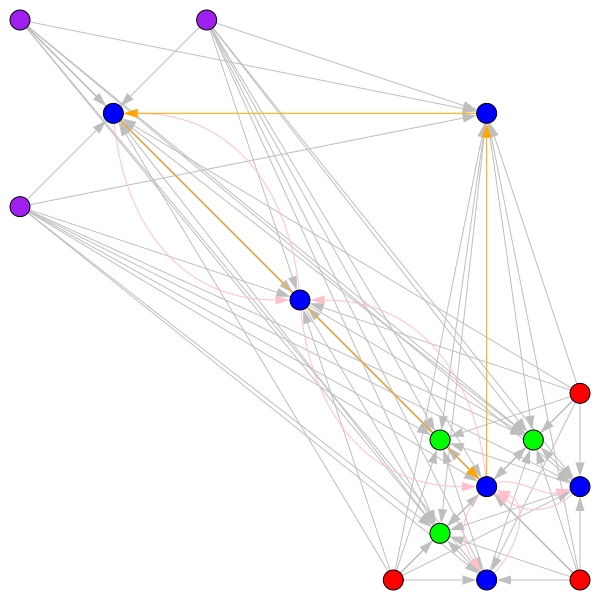

In [3]:
ig.plot(g)

In [4]:
census

,neighborhood,n_inh,n_purple,n_red,geometry
0,RC1,1000,100,900,POINT (3.50000 3.50000)
1,RC2,1000,200,800,POINT (2.50000 3.50000)
2,RC3,1000,200,800,POINT (3.50000 2.50000)
3,RC4,1200,1000,200,POINT (0.50000 1.50000)
4,RC5,800,600,200,POINT (0.50000 0.50000)
5,RC6,1000,1000,0,POINT (1.50000 0.50000)


# Helper Functions

In [5]:
g.vs.select(type_eq='res_node')['name']

['RC1', 'RC2', 'RC3', 'RC4', 'RC5', 'RC6']

In [6]:
def evaluate_graph(g: ig.Graph) -> pd.DataFrame:
    nb_nodes = g.vs.select(type_eq='res_node')
    poi_nodes = g.vs.select(type_eq='poi_node')

    tt_mx = np.zeros((len(nb_nodes), len(poi_nodes)))
    hops_mx = np.zeros((len(nb_nodes), len(poi_nodes)))

    failed = {}

    for i, o in enumerate(nb_nodes):
        for j, d in enumerate(poi_nodes):
            # Travel Time
            tt = g.shortest_paths(o, d, weights='tt')[0][0]
            if tt == math.inf:
                if not failed.get(f"{o['node_id']}_tt", None) == d['node_id']:
                    failed[f"{o['node_id']}_tt"] = d["node_id"]
            else:
                tt_mx[i, j] = tt
            # Number of hops
            edges = g.get_shortest_paths(o, d, weights='tt', output='epath')[0]
            if edges == math.inf or not edges:
                if not failed.get(f"{o['node_id']}_edges", None) == d["node_id"]:
                    failed[f"{o['node_id']}_edges"] = d["node_id"]
            else:
                hops_mx[i, j] = len(edges)

    df_tt = pd.DataFrame(tt_mx, columns=poi_nodes['name'])
    df_tt['metric'] = 'travel_time'
    df_tt['rc'] = nb_nodes['name']

    df_hops = pd.DataFrame(hops_mx, columns=poi_nodes['name'])
    df_hops['metric'] = 'hops'
    df_hops['rc'] = nb_nodes['name']

    return pd.concat([df_tt,df_hops], axis=0)

In [7]:
df = evaluate_graph(g)
df

,POI1,POI2,POI3,metric,rc
0,10.542641,9.486833,9.486833,travel_time,RC1
1,9.486833,4.242641,11.191324,travel_time,RC2
2,9.486833,10.542641,4.242641,travel_time,RC3
3,12.940054,12.940054,12.940054,travel_time,RC4
4,12.940054,12.940054,12.940054,travel_time,RC5
5,12.940054,12.940054,12.940054,travel_time,RC6
0,3.000000,1.000000,1.000000,hops,RC1
1,1.000000,1.000000,3.000000,hops,RC2
2,1.000000,3.000000,1.000000,hops,RC3
3,3.000000,3.000000,3.000000,hops,RC4


In [8]:
def generate_samples(metric_df: pd.DataFrame, inh_per_group: pd.DataFrame) -> pd.DataFrame:
    merged_df = pd.merge(metric_df, inh_per_group, how='left', left_on='rc', right_on='neighborhood')

    city = pd.DataFrame(columns=['metric_value', 'group'])

    for group in merged_df.loc[:,merged_df.columns.str.contains('n_')].columns:
        samples_group = np.repeat(merged_df['average'].values, merged_df[group])
        samples_group = samples_group.reshape((-1,1))
        labels = np.repeat(group.replace('n_',''),samples_group.shape[0]).reshape((-1,1))
        group_individuals = np.hstack([samples_group, labels])
        df = pd.DataFrame(group_individuals, columns=['metric_value', 'group'])
        city = pd.concat([city, df], axis=0)

    return city

In [9]:
def get_tt_hops_com_dfs(g: ig.Graph, census_data: pd.DataFrame) -> Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]:
    metric_df = evaluate_graph(g)
    groups_census = census_data.drop(columns=['n_inh','geometry'])

    metric_df['average'] = metric_df.loc[:,metric_df.columns.str.contains('POI')].mean(axis=1)
    tt_samples = generate_samples(metric_df[metric_df['metric']=='travel_time'], groups_census)
    hops_samples = generate_samples(metric_df[metric_df['metric']=='hops'], groups_census)

    value_cols = metric_df.loc[:,metric_df.columns.str.contains('POI')]
    metric_df['average'] = (value_cols<12).sum(axis=1)
    com_samples = generate_samples(metric_df[metric_df['metric']=='travel_time'], groups_census)

    return tt_samples, hops_samples, com_samples

In [10]:
def series_min_max_norm(sr: pd.Series):
    return (sr-sr.min())/(sr.max()-sr.min())

# Reward Functions

In [11]:
def egalitarian(g: ig.Graph, census_data: gpd.GeoDataFrame, groups: List[str] = None) -> float:

    tt_samples, hops_samples, com_samples = get_tt_hops_com_dfs(g, census_data)

    groups = list(tt_samples.group.unique()) if not groups else groups
    assert isinstance(groups, list)

    # fit KDE (sklearn) on each component
    kdes = {group: {metric: None for metric in ['tt','hops','com']} for group in groups}
    kde_mixtures = {metric: None for metric in ['tt','hops','com']}

    for group in groups:
        for metric, metric_df in zip(['tt','hops','com'], [tt_samples, hops_samples, com_samples]):
            X = metric_df[metric_df.group==group].drop(columns='group').astype(float).to_numpy()
            kde = sm.nonparametric.KDEUnivariate(X)
            kde.fit(bw=0.2)
            kdes[group][metric] = kde
        #     # score_samples returns the log of the probability density
        #     x_d = np.linspace(0,X.max()+5, 100).reshape((-1,1))
        #     logprob = kde.score_samples(x_d)
        #     x_d = np.linspace(0,X.max()+5, 100)
        #     plt.fill_between(x_d, np.exp(logprob), alpha=0.5)
        #     plt.plot(X, np.full_like(X, -0.01), '|k', markeredgewidth=1)
        #     break
        # break

    for metric, metric_df in zip(['tt','hops','com'], [tt_samples, hops_samples, com_samples]):
        X = metric_df.drop(columns='group').astype(float).to_numpy()
        kde = sm.nonparametric.KDEUnivariate(X)
        kde.fit(bw=0.2)
        kde_mixtures[metric] = kde

    reward = 0
    for metric in ['tt','hops','com']:
        n_dist = len(kdes.keys())
        reward += kde_mixtures[metric].entropy - 1/n_dist * sum([kdes[group][metric].entropy  for group in kdes])

    return -reward

In [12]:
egalitarian(g, census)

-0.809928924341548

In [13]:
def utilitarian(g: ig.Graph, census_data: gpd.GeoDataFrame, groups: List[str] = None) -> float:
    # TODO: Look into multi-obj. learning but for now just consider one at a time or with weights
    tt_samples, hops_samples, com_samples = get_tt_hops_com_dfs(g, census_data)

    groups = tt_samples.group.unique() if not groups else groups

    tt_samples_hat = tt_samples
    hops_samples_hat = hops_samples
    com_samples_hat = com_samples

    tt_samples_hat['metric_value'] = series_min_max_norm(tt_samples.metric_value.astype(float))
    hops_samples_hat['metric_value'] =  series_min_max_norm(hops_samples.metric_value.astype(float))
    com_samples_hat['metric_value'] = series_min_max_norm(com_samples.metric_value.astype(float))

    reward = 0

    for group in groups:
        reward += -float(np.mean(tt_samples_hat[tt_samples_hat.group==group]['metric_value']))\
                  -float(np.mean(hops_samples_hat[hops_samples_hat.group==group]['metric_value']))\
                  +float(np.mean(com_samples_hat[com_samples_hat.group==group]['metric_value']))

    return reward

In [14]:
utilitarian(g, census)

-1.0685986858449785

In [15]:
def elitarian(g: ig.Graph, census_data: gpd.GeoDataFrame, group: str) -> float:
    # TODO: Use only utilitarian approach maybe

    return egalitarian(g, census_data, [group]) + utilitarian(g, census_data, [group])

In [16]:
elitarian(g, census, 'red')

-0.14050322836186213

In [17]:
def ai_economist_reward(g: ig.Graph, census_data: gpd.GeoDataFrame) -> float:
    # Total utility of all groups * (1-gini_index between groups)
    pass

# Random Baseline

In [ ]:
budget =  5
reward = egalitarian

g_prime = copy(g)

for i in range(budget):
    removable_edges = g_prime.es.select(type_ne='walk')
    edge_to_remove = random.sample(list(removable_edges), 1)[0]
    g_prime.delete_edges(edge_to_remove)
    r = reward(g_prime, census)
    print(r)

ig.plot(g_prime)

# Fully Informed Greedy Baseline

In [ ]:
def greedy_baseline(g: ig.Graph, census_data: pd.DataFrame, budget: int = 5, reward_func: callable = egalitarian):

    g_prime = copy(g)

    assert budget > 0

    removed_edges = []

    for i in range(budget):
        removable_edges = g_prime.es.select(type_ne='walk')
        all_rewards = {}
        for edge in removable_edges:
            g_star = copy(g_prime)
            g_star.delete_edges(edge)
            r = reward_func(g_star, census_data)
            all_rewards[r] = edge
        max_reward = max(all_rewards.keys())
        edge_to_remove = all_rewards[max_reward]
        removed_edges.append(edge_to_remove)
        g_prime.delete_edges(edge_to_remove)
        print(max_reward)

    return g_prime, removed_edges, max_reward

g_prime, _, _ = greedy_baseline(g, census, 5, egalitarian)
ig.plot(g_prime)

# Genetic Algorithm Baseline

In [ ]:
removable_edges = g.es.select(type_ne='walk').indices
reward_func = egalitarian
budget = 5

def individual_fitness(solution, solution_idx):
    g_prime = copy(g)
    g_prime.delete_edges(solution)
    r = reward_func(g_prime, census)
    return r

ga_instance = pygad.GA(
    num_generations=200,
    num_parents_mating=5,
    fitness_func=individual_fitness,
    initial_population=None,
    sol_per_pop=5,
    num_genes=budget,
    gene_type=int,
    parent_selection_type="sss",
    crossover_type="single_point",
    crossover_probability=0.4,
    mutation_type="random",
    mutation_probability=0.4,
    mutation_by_replacement=False,
    mutation_percent_genes="default",
    mutation_num_genes=None,
    gene_space=list(removable_edges),
    # on_start=None,
    # on_fitness=None,
    # on_parents=None,
    # on_crossover=None,
    # on_mutation=None,
    # callback_generation=None,
    # on_generation=None,
    # on_stop=None,
    delay_after_gen=0.0,
    save_best_solutions=True,
    save_solutions=False,
    suppress_warnings=False,
    stop_criteria='saturate_20',
)

In [ ]:
ga_instance.run()

In [ ]:
solution, solution_fitness, solution_idx = ga_instance.best_solution()
print("Parameters of the best solution : {solution}".format(solution=solution))
print("Fitness value of the best solution = {solution_fitness}".format(solution_fitness=solution_fitness))

g_prime = copy(g)
g_prime.delete_edges(solution)
ig.plot(g_prime)

# maxQ-Learning

In [18]:
# Not sure about the undo action
BASE_GRAPH = g
START = ()
GOAL = 5  # Budget
ALPHA = 0.5  # step size
EPSILON = 0.1  # probability for exploration
GAMMA = 1
ACTIONS = [e.index for e in g.es.select(type_ne='walk')]
REWARD_FUNC = egalitarian

In [19]:
def get_state_key(removed_edges: Tuple) -> Tuple:
    return tuple(np.sort(list(removed_edges)))

def step(state, action_idx):
    # TODO: Consider scaling the probabilities of not-allowed actions
    g_prime = copy(BASE_GRAPH)

    try:
        edge_idx = ACTIONS[action_idx]
        if edge_idx in state:
            raise ValueError("Cannot choose same action twice")
        next_state = state + (edge_idx,)
        g_prime.delete_edges([(e.source_vertex.index, e.target_vertex.index) for e in BASE_GRAPH.es[list(next_state)]])
        reward = REWARD_FUNC(g_prime, census)
    except ValueError:
        reward = -100
        next_state = START

    return next_state, reward


# choose an action based on epsilon greedy algorithm
def choose_action(state: tuple, q_value: dict, epsilon: float):
    if np.random.binomial(1, epsilon) == 1:
        return np.random.choice(range(len(ACTIONS)))
    else:
        values_ = q_value[state]
        return np.random.choice([action_ for action_, value_ in enumerate(values_) if value_ == np.max(values_)])


In [20]:
def q_learning(q_value, step_size=ALPHA, epsilon=EPSILON):
    ord_state = get_state_key(START)
    rewards = []
    while len(ord_state) != GOAL:
        action = choose_action(ord_state, q_value, epsilon)
        next_state, reward = step(ord_state, action)
        next_ord_state = get_state_key(next_state)
        rewards += reward
        # Q-Learning update
        q_value[ord_state][action] += step_size * (
                reward + GAMMA * np.max(q_value[next_ord_state]) -
                q_value[ord_state][action])
        ord_state = next_ord_state
    return rewards

In [36]:
def max_q_learning(q_value, step_size=ALPHA, epsilon=EPSILON):
    ord_state = get_state_key(START)
    reward = -np.inf
    while len(ord_state) != GOAL:
        action = choose_action(ord_state, q_value, epsilon)
        next_state, reward = step(ord_state, action)
        next_ord_state = get_state_key(next_state)
        # Q-Learning update
        q_value[ord_state][action] += step_size * (
                reward + GAMMA * np.max(q_value[next_ord_state]) +
                q_value[ord_state][action])
        ord_state = next_ord_state
    return reward


In [33]:
def sarsa(q_value: dict, expected=False, step_size: float = ALPHA, epsilon=EPSILON) -> float:
    ord_state = get_state_key(START)
    action = choose_action(ord_state, q_value, epsilon)
    rewards = 0.0
    while len(ord_state) != GOAL:
        next_state, reward = step(ord_state, action)
        next_ord_state = get_state_key(next_state)
        next_action = choose_action(next_ord_state, q_value, epsilon)
        rewards += reward
        if not expected:
            target = q_value[next_ord_state][next_action]
        else:
            # calculate the expected value of new state
            target = 0.0
            q_next = q_value[next_ord_state]
            best_actions = np.argwhere(q_next == np.max(q_next))
            for action_ in ACTIONS:
                if action_ in best_actions:
                    target += ((1.0 - EPSILON) / len(best_actions) + EPSILON / len(ACTIONS)) * q_value[next_ord_state][action_]
                else:
                    target += EPSILON / len(ACTIONS) * q_value[next_ord_state][action_]
        target *= GAMMA
        q_value[ord_state][action] += step_size * (
                reward + target - q_value[ord_state][action])
        # Updating
        ord_state = next_ord_state
        action = next_action
    return rewards


In [37]:
episodes = 100

# rewards_sarsa = np.zeros(episodes)
# rewards_exp_q_learning = np.zeros(episodes)
rewards_max_q_learning = np.zeros(episodes)
# https://math.stackexchange.com/a/144258
# Sum of nCk for k in [0,n] = 2^n
# As our indexing starts at 1, we have (2^n)-1
# state_space_size = (2**len(ACTIONS)-1,1,len(ACTIONS))
# for r in tqdm(range(runs)):
# q_values = {get_state_key(tuple(e)): np.zeros(len(ACTIONS)) for k in range(GOAL+1) for e in it.combinations(ACTIONS, k)}
# exp_q_learning_values = copy(q_values)
max_q_learning_values = {get_state_key(tuple(e)): np.zeros(len(ACTIONS)) for k in range(GOAL+1) for e in it.combinations(ACTIONS, k)}
for i in tqdm(range(0, episodes)):
    # rewards_sarsa[i] += sarsa(q_values)
    # rewards_exp_q_learning[i] += q_learning(exp_q_learning_values)
    rewards_max_q_learning[i] += max_q_learning(max_q_learning_values, epsilon=1/(i+1))

# averaging over independent runs
# rewards_sarsa /= runs
# rewards_q_learning /= runs

100%|██████████| 100/100 [04:45<00:00,  2.85s/it]


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


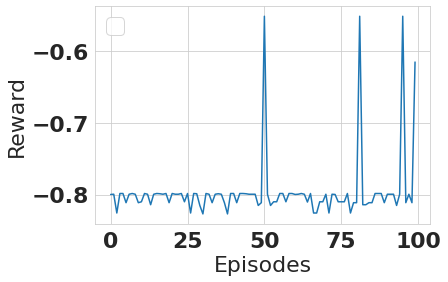

In [39]:
# draw reward curves
# plt.plot(rewards_sarsa, label='Sarsa')
plt.plot(rewards_max_q_learning)
plt.xlabel('Episodes')
# plt.xlim([0, 500])
plt.ylabel('Reward')
# plt.ylim([-60, 0])
plt.legend()

# Analysis

In [41]:
# Show that for any permutation, the final result is the same
removable_edges = list(g.es.select(type_ne='walk'))

k = 3
group = 'red'

random_k = random.sample(removable_edges, k)

g_prime = copy(g)
g_prime.delete_edges(random_k)

r_ega = egalitarian(g_prime, census)
r_uti = utilitarian(g_prime, census)
r_eli = elitarian(g_prime, census, group)

for perm in it.permutations(random_k, k):
    g_prime = copy(g)
    g_prime.delete_edges(random_k)
    r_ega_prime = egalitarian(g_prime, census)
    r_uti_prime = utilitarian(g_prime, census)
    r_eli_prime = elitarian(g_prime, census, group)

    assert np.isclose(r_ega_prime, r_ega)
    assert np.isclose(r_uti_prime, r_uti)
    assert np.isclose(r_eli_prime, r_eli)


In [ ]:
# Compute Gini index for all combinations to max budget
removable_edges = list(g.es.select(type_ne='walk'))

max_budget = len(removable_edges)

for k in range(max_budget):
    generate_samples()
    Gini()

In [ ]:
# Compute mega components for each combination of k budget
removable_edges = g.es.select(type_ne='walk')
mc_over_budget = pd.DataFrame(columns=['budget','mc'])

for k in tqdm(range(1,len(removable_edges)), position=0):
    # looking at all possible combinations of edges to remove
    for edges_to_remove in it.combinations(removable_edges, k):
        g_prime = copy(g)
        g_prime.delete_edges(edges_to_remove)
        cl = g_prime.clusters()
        lcc = cl.giant()

        data = {'budget':[k], 'mc':[len(lcc.es)]}
        mc_over_budget = pd.concat([mc_over_budget,pd.DataFrame(data)], ignore_index=True)

mc_over_budget['budget'] = mc_over_budget['budget'].astype('int')

In [ ]:
fig, ax = plt.subplots()
mc_over_budget.plot.scatter(x='budget', y='mc', cmap="viridis", s=50, legend=True, figsize=(5,5), ax=ax)
ax.set_xlabel('Edge Budget')
ax.set_xticks(range(len(list(removable_edges))))
ax.set_yticks(range(11))
ax.set_ylabel('Size of Mega Component')

In [ ]:
# Compute Gini index for all combinations to max budget
removable_edges = g.es.select(type_ne='walk')
gini_over_budget = pd.DataFrame(columns=['budget','gini','metric','group'])

for k in tqdm(range(1,len(removable_edges)), position=0):
    # looking at all possible combinations of edges to remove
    for edges_to_remove in it.combinations(removable_edges, k):
        g_prime = copy(g)
        g_prime.delete_edges(edges_to_remove)
        tt_samples, hops_samples, com_samples = get_tt_hops_com_dfs(g_prime, census)

        data = {'budget':[],
                'gini':[],
                'metric':[],
                'group':[]}
        for metric_name, metric in zip(['tt','hops','com'], [tt_samples, hops_samples, com_samples]):
            for group in list(tt_samples.group.unique()):
                data['budget'].append(k)
                data['group'].append(group)
                data['gini'].append(Gini(metric.metric_value.astype(float).to_numpy()).g)
                data['metric'].append(metric_name)

        gini_over_budget = pd.concat([gini_over_budget,pd.DataFrame(data)], ignore_index=True)

gini_over_budget['metric'] = gini_over_budget['metric'].astype('category')
gini_over_budget['budget'] = gini_over_budget['budget'].astype('int')

In [ ]:
fig, ax = plt.subplots(figsize=(10,10))
gini_over_budget.plot.scatter(x='budget', y='gini', c='metric', cmap="Dark2", s=50, legend=True, figsize=(10,10), ax=ax)
ax.set_yticks(np.arange(0,0.7,0.05))
ax.set_xticks(np.arange(0,12))
ax.set_ylabel('Gini')
ax.set_xlabel('Edge Budget')

In [ ]:
## Random Baseline


In [ ]:
## Fully informed greedy

In [ ]:
## GA

In [ ]:
# Show same for mega-components

In [ ]:
# TODO plot utilities red over purple compare that gini
# TODO compare avg. utility to lowest group utility